<a href="https://colab.research.google.com/github/odheL42/NSU-senior-project/blob/main/tested_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Импорт необходимых модулей

In [1]:
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow
import glob
import numpy as np
import pandas as pd

In [2]:
frame = 2500
frame_path = '/content/drive/MyDrive/dataset_nsu_senProj/result_cutted_2/sample_video_img_'+ str(frame) +'.jpg'

# Детектирование капель, определение их контура (стандарт)

In [ ]:
data=[]
idx=-1
output_csv = '/content/drive/MyDrive/dataset_nsu_senProj/result_cutted_2/droplet_parameters_fin.csv'

for file in glob.glob('/content/drive/MyDrive/dataset_nsu_senProj/result_cutted_2/*.jpg'):
    #img = img[86:170, 325:900]
    idx+=1
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blurred = cv2.medianBlur(gray, 25) #cv2.bilateralFilter(gray,10,50,50)
    #увеличение резкости изображения
    kernel1 = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    img = cv2.filter2D(img, -1, kernel)

    #медианный фильтр
    img  = cv2.medianBlur(img,5)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = gray

    minDist = 100
    param1 = 30 #500
    param2 = 20 #200 #smaller value-> more false circles
    minRadius = 22
    maxRadius = 45 #10



    # docstring of HoughCircles: HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)

    data.append({
            'Frame Number': idx,
            'Radius (mm)': i[2]*0.011,
            'Diameter (mm)': i[2]*2*0.011,
            'Volume (mm)': 4/3*(np.pi*i[2]*0.011)
        })
df = pd.DataFrame(data)
df.to_csv(output_csv, index=False)

print(f"Данные сохранены в {output_csv}")

In [ ]:
df = pd.DataFrame(data)
output_csv = '/content/drive/MyDrive/dataset_nsu_senProj/result_cutted_1/droplet_parameters.csv'
df.to_csv(output_csv, index=False)

print(f"Данные сохранены в {output_csv}")

In [ ]:
df = pd.read_csv(output_csv)
df.head()
test = df.mean(axis='index')
print(test)
min = df.min(axis='index')
print(min)
max= df.max(axis='index')
print(max)

# Ищем ось симметрии

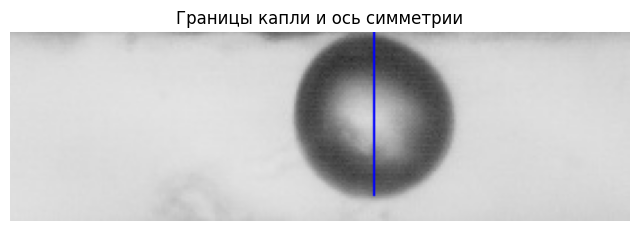

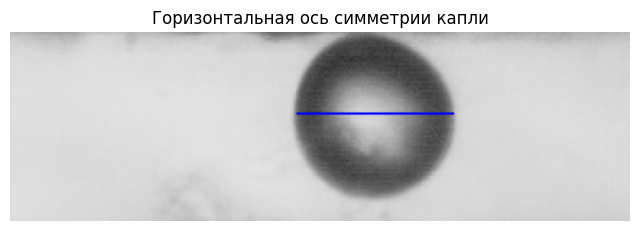

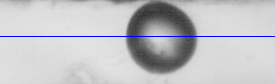

In [58]:
import matplotlib.pyplot as plt
def find_droplet_boundaries_and_symmetry_axis(image_path):
    # Загрузка изображения в градациях серого
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    #image = image[86:170, :500]
    if image is None:
        raise ValueError(f"Не удалось загрузить изображение: {image_path}")

    # Применение порогового преобразования для сегментации капель
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

    # Поиск контуров
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Игнорируем слишком маленькие контуры
        if cv2.contourArea(contour) < 100:
            continue

        # Создание ограничивающего прямоугольника
        x, y, w, h = cv2.boundingRect(contour)
        top_boundary = y
        bottom_boundary = y + h

        # Вычисление оси симметрии как средняя линия по горизонтали
        symmetry_axis = x + w // 2
        res_x = symmetry_axis

        # Отображение результатов
        image_with_boundaries = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        #cv2.line(image_with_boundaries, (x, top_boundary), (x + w, top_boundary), (0, 255, 0), 1)
        #cv2.line(image_with_boundaries, (x, bottom_boundary), (x + w, bottom_boundary), (0, 0, 255), 1)
        cv2.line(image_with_boundaries, (symmetry_axis, top_boundary), (symmetry_axis, bottom_boundary), (255, 0, 0), 1)

        # Отображение изображения с границами и осью симметрии
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(image_with_boundaries, cv2.COLOR_BGR2RGB))
        plt.title("Границы капли и ось симметрии")
        plt.axis('off')
        plt.show()

        # Создание ограничивающего прямоугольника
        x, y, w, h = cv2.boundingRect(contour)
        left_boundary = x
        right_boundary = x + w

        # Вычисление горизонтальной оси симметрии как средней линии по вертикали
        symmetry_axis = y + h // 2
        res_y = symmetry_axis

        # Отображение результатов
        image_with_boundaries = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.line(image_with_boundaries, (left_boundary, symmetry_axis), (right_boundary, symmetry_axis), (255, 0, 0), 1)
        #cv2.rectangle(image_with_boundaries, (x, y), (x + w, y + h), (0, 255, 0), 1)

        # Отображение изображения с горизонтальной осью симметрии и ограничивающим прямоугольником
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(image_with_boundaries, cv2.COLOR_BGR2RGB))
        plt.title("Горизонтальная ось симметрии капли")
        plt.axis('off')
        plt.show()

        return (res_x, res_y)

# Пример использования
image_path = frame_path
sym_x, sym_y = find_droplet_boundaries_and_symmetry_axis(image_path)

img = cv2.imread(image_path)
#img = img[87:170, :900]
height, width = img.shape[:2]
cv2.line(img, (0, sym_y), (width, sym_y), (255, 0, 0), 1)
cv2_imshow(img)

Нижняя половина


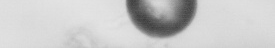

Верхняя половина


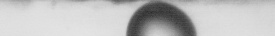

In [45]:
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img_bottom_half = img[sym_y:, :]
print('Нижняя половина')
cv2_imshow(img_bottom_half)

img_upper_half = img[:sym_y, :]
print('Верхняя половина')
cv2_imshow(img_upper_half)

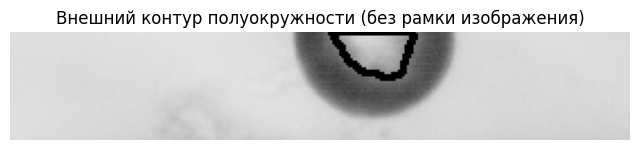

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # 1. Загрузка исходного изображения
    image_path = 'path_to_your_image.jpg'
    image = img_bottom_half
    if image is None:
        raise ValueError("Не удалось загрузить изображение!")

    # 2. Преобразование в оттенки серого и бинаризация
    _, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # 3. Поиск контуров (только внешних)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("Контуры не найдены!")

    h, w = thresh.shape[:2]
    img_area = w * h

    valid_contours = []
    for cnt in contours:
        x, y, cw, ch = cv2.boundingRect(cnt)
        # Если boundingRect почти не покрывает всё изображение (например, < 95%),
        # то считаем, что это не рамка.
        # Иначе — игнорируем, т.к. это, скорее всего, граница всего изображения.
        if cw * ch < 0.95 * img_area:
            valid_contours.append(cnt)

    if not valid_contours:
        raise ValueError("Все контуры оказались рамками или слишком большими!")

    # 4. Выбираем самый большой контур по площади
    main_contour = max(valid_contours, key=cv2.contourArea)

    # 5. Отрисовка результата
    output = image.copy()
    # Рисуем контур капли, не удаляя точки, которые лежат на границе
    cv2.drawContours(output, [main_contour], -1, (0, 255, 0), 2)

    plt.figure(figsize=(8, 4))
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("Внешний контур полуокружности (без рамки изображения)")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


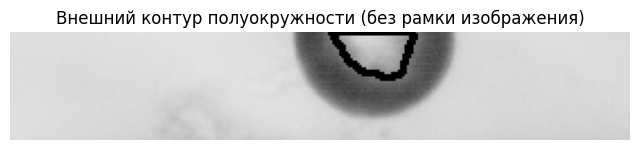

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # 1. Загрузка исходного изображения
    image_path = 'path_to_your_image.jpg'
    image = img_bottom_half
    if image is None:
        raise ValueError("Не удалось загрузить изображение!")

    # 2. Преобразование в оттенки серого и бинаризация
    _, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # 3. Поиск контуров с иерархией (RETR_TREE)
    #    CHAIN_APPROX_SIMPLE для упрощённого хранения точек
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours or hierarchy is None:
        raise ValueError("Контуры не найдены!")

    h, w = thresh.shape[:2]
    img_area = w * h

    # 4. Ищем контуры, у которых нет родителя (parent == -1) => внешний
    #    При этом исключаем рамку, которая занимает почти всё изображение
    valid_contours = []
    # hierarchy имеет вид (N,1,4). Для i-го контура hierarchy[0][i] = [next, prev, child, parent]
    for i, cnt in enumerate(contours):
        # parent = hierarchy[0][i][3]
        parent = hierarchy[0][i][3]
        if parent == -1:  # нет родителя => внешний контур
            x, y, cw, ch = cv2.boundingRect(cnt)
            area = cw * ch
            # исключаем, если контур покрывает более 95% всей картинки
            if area < 0.95 * img_area:
                valid_contours.append(cnt)

    if not valid_contours:
        raise ValueError("Все внешние контуры оказались рамкой или не найдены.")

    # 5. Выбираем самый большой по площади (или другой критерий)
    main_contour = max(valid_contours, key=cv2.contourArea)

    # 6. Отрисовка результата
    output = image.copy()
    cv2.drawContours(output, [main_contour], -1, (0, 255, 0), 2)

    plt.figure(figsize=(8, 4))
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("Внешний контур полуокружности (без рамки изображения)")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка изображения

image = img_bottom_half
if image is None:
    raise ValueError("Не удалось загрузить изображение!")


# Бинаризация изображения (порог 127, можно скорректировать)
_, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Поиск контуров (используем внешний контур)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Если найдено несколько контуров, можно выбрать контур с наибольшей площадью
if contours:
    main_contour = max(contours, key=cv2.contourArea)
else:
    raise ValueError("Контуры не найдены!")

# Получаем размеры изображения
height, width = thresh.shape[:2]

# Фильтрация точек: исключаем те, что находятся на границе изображения
filtered_points = []
for point in main_contour:
    x, y = point[0]
    # Если точка не находится на границе изображения (с допуском 1 пиксель)
    if x != 0 and x != width - 1 and y != 0 and y != height - 1:
        filtered_points.append([x, y])

# Преобразуем список точек в нужный формат (numpy array с формой (-1, 1, 2))
if len(filtered_points) > 0:
    filtered_contour = np.array(filtered_points, dtype=np.int32).reshape((-1, 1, 2))
else:
    raise ValueError("Нет точек контура, не лежащих на границе изображения.")

# Отрисовка результата
output = image.copy()
cv2.drawContours(output, [filtered_contour], -1, (0, 255, 0), 1)

# Отображение с использованием matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Внешний контур полуокружности (без границы изображения)")
plt.axis('off')
plt.show()


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/contours_new.cpp:327: error: (-2:Unspecified error) in function 'static std::shared_ptr<ContourScanner_> ContourScanner_::create(cv::Mat, int, int, cv::Point)'
> Modes other than RETR_FLOODFILL and RETR_CCOMP support only CV_8UC1 images (expected: 'img.type() == CV_8UC1'), where
>     'img.type()' is 16 (CV_8UC3)
> must be equal to
>     'CV_8UC1' is 0 (CV_8UC1)


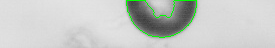

'# Применение порогового преобразования для сегментации капель\n_, binary_image = cv2.threshold(img_upper_half, 255, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)\n\n# Поиск контуров\ncontours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\n\n# Отрисовка контуров на исходном изображении\nresult1 = cv2.cvtColor(img_upper_half, cv2.COLOR_GRAY2BGR)\ncv2.drawContours(result1, contours, -1, (0, 255, 0), 1)\n\n# Отображение результата\ncv2_imshow( result1)'

In [40]:
# Применение порогового преобразования для сегментации капель
_, binary_image = cv2.threshold(img_bottom_half, 250, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Поиск контуров
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Отрисовка контуров на исходном изображении
result = cv2.cvtColor(img_bottom_half, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result, contours, -1, (0, 255, 0), 1)

# Отображение результата
cv2_imshow( result)


'''# Применение порогового преобразования для сегментации капель
_, binary_image = cv2.threshold(img_upper_half, 255, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Поиск контуров
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Отрисовка контуров на исходном изображении
result1 = cv2.cvtColor(img_upper_half, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result1, contours, -1, (0, 255, 0), 1)

# Отображение результата
cv2_imshow( result1)'''

# Обрабатываем нижнюю половину

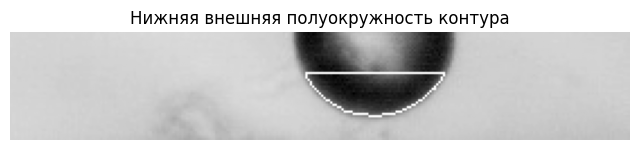

In [41]:
# Применение порогового преобразования для выделения капли
#_, binary_image = cv2.threshold(img_bottom_half, 250, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Поиск контуров
#contours, _ = cv2.findContours(result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Предполагается, что есть один главный контур
if len(contours) > 0:
    contour = max(contours, key=cv2.contourArea)

    # Найдём центр контура
    M = cv2.moments(contour)
    if M["m00"] == 0:
        print('pepe')

    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # Разделим контур на внутреннюю и внешнюю части
    outer_points = []
    for point in contour:
        x, y = point[0]
        # Сохраняем точки, которые находятся ниже центра
        if y > cy:  # Оставляем только внешнюю полуокружность ниже центра
            outer_points.append([x, y])

    # Преобразование списка в формат NumPy
    outer_contour = np.array(outer_points).reshape((-1, 1, 2)).astype(np.int32)

    # Создание пустого изображения для отрисовки
    result_image = np.zeros_like(img_bottom_half)
    cv2.drawContours(img_bottom_half, [outer_contour], -1, 255, 1)

    # Отображение результата
    plt.figure(figsize=(8, 8))
    plt.imshow(img_bottom_half, cmap='gray')
    plt.title("Нижняя внешняя полуокружность контура")
    plt.axis('off')
    plt.show()

#Обрабатываем верхнюю половину

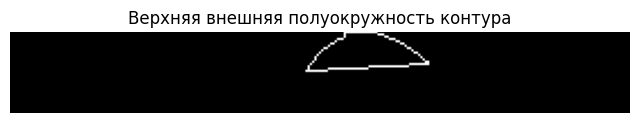

In [7]:
# Применение порогового преобразования для выделения капли
_, binary_image = cv2.threshold(img_upper_half, 250, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Поиск контуров
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) > 0:
    contour = max(contours, key=cv2.contourArea)

    # Найдём центр контура
    M = cv2.moments(contour)
    if M["m00"] == 0:
        print('pepe')

    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # Разделим контур на внутреннюю и внешнюю части
    outer_points = []
    for point in contour:
        x, y = point[0]
        # Сохраняем точки, которые находятся дальше от центра
        if y < cy:  # Оставляем только внешнюю полуокружность выше центра
            outer_points.append([x, y])

    # Преобразование списка в формат NumPy
    outer_contour = np.array(outer_points).reshape((-1, 1, 2)).astype(np.int32)

    # Создание пустого изображения для отрисовки
    result_image = np.zeros_like(img_upper_half)
    cv2.drawContours(result_image, [outer_contour], -1, 255, 1)

    # Отображение результата
    plt.figure(figsize=(8, 8))
    plt.imshow(result_image, cmap='gray')
    plt.title("Верхняя внешняя полуокружность контура")
    plt.axis('off')
    plt.show()

# Считаем объем по нижней полуокружности

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def calculate_volume_from_half_contour(contour, scale):
    """
    Рассчитывает объём объекта методом усечённых конусов на основе половины контура,
    отсечённого по горизонтальной оси симметрии.

    Параметры:
    - contour: np.array, контур половины объекта.
    - scale: float, коэффициент перевода из пикселей в миллиметры.

    Возвращает:
    - volume: float, объём объекта в кубических миллиметрах.
    """
    # Сортируем точки контура по x (горизонтальной оси)
    sorted_contour = contour[np.argsort(contour[:, 0, 0])]
    xs = sorted_contour[:, 0, 0]  # Горизонтальные координаты (x)
    ys = sorted_contour[:, 0, 1]  # Вертикальные координаты (y)

    # Определяем горизонтальную ось симметрии
    y_center = max(ys)  # Верхняя граница капли — ось симметрии

    volume = 0

    # Интегрируем по x с шагом в 1 пиксель
    for i in range(1, len(xs)):
        x_prev, x_cur = xs[i-1], xs[i]
        y_prev, y_cur = ys[i-1], ys[i]

        # Высота усечённого конуса (разница по x) в миллиметрах
        h = abs(x_cur - x_prev) * scale

        # Нижний и верхний радиусы в миллиметрах (учитываем симметрию)
        Dbot = abs(y_prev - y_center) * 2 * scale  # Удваиваем радиусы
        Dtop = abs(y_cur - y_center) * 2 * scale

        # Вычисляем объём усечённого конуса
        Vi = (np.pi * h / 12) * (Dbot**2 + Dbot * Dtop + Dtop**2)
        volume += Vi

    return volume

'''# Пример использования
# Загружаем изображение и находим контур половины капли
image_path = 'path_to_your_image.png'  # Укажите путь к вашему изображению
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)'''

# Предполагаем, что нужный контур — это самый большой
half_contour = max(contours, key=cv2.contourArea)

# Масштабный коэффициент (например, 0.1 мм на пиксель)
scale = 0.011

# Вычисляем объём
volume_method2 = calculate_volume_from_half_contour(outer_contour, scale)
print(f"Объём капли: {volume_method2:.4f} мм³")


Объём капли: 0.0138 мм³


#Сравниваем результаты

In [ ]:
#/content/drive/MyDrive/dataset_nsu_senProj/result_cutted_2/sample_video_img_2500.jpg
frame = 2500
frame_path = '/content/drive/MyDrive/dataset_nsu_senProj/result_cutted_2/sample_video_img_'+ str(frame) +'.jpg'

img = cv2.imread(frame_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.medianBlur(gray, 25) #cv2.bilateralFilter(gray,10,50,50)
#увеличение резкости изображения
kernel1 = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img = cv2.filter2D(img, -1, kernel)

#медианный фильтр
img  = cv2.medianBlur(img,5)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = gray

minDist = 100
param1 = 30 #500
param2 = 20 #200 #smaller value-> more false circles
minRadius = 22
maxRadius = 45 #10



# docstring of HoughCircles: HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)


volume_method1 = 4/3*(np.pi*(i[2]*0.011/100))


In [ ]:
print(f'Объём капли по методу дисков на кадре {frame}: {volume_method2:.4f} мм³')
print(f'Объём капли по методу приближения к окружности на кадре {frame}: {volume_method1:.4f} мм³')

Объём капли по методу дисков на кадре 2500: 0.0138 мм³
Объём капли по методу приближения к окружности на кадре 2500: 0.0147 мм³


# Считаем объем капель для всех кадров, сохраняем в csv

In [ ]:
data=[]
idx=-1
output_csv = '/content/drive/MyDrive/dataset_nsu_senProj/result_cutted_2/droplet_parameters_disks.csv'
for file in glob.glob('/content/drive/MyDrive/dataset_nsu_senProj/result_cutted_2/*.jpg'):
    idx+=1
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    #image = image[86:170, :500]
    if image is None:
        raise ValueError(f"Не удалось загрузить изображение: {file}")

    # Применение порогового преобразования для сегментации капель
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

    # Поиск контуров
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Игнорируем слишком маленькие контуры
        if cv2.contourArea(contour) < 100:
            continue

        # Создание ограничивающего прямоугольника
        x, y, w, h = cv2.boundingRect(contour)
        top_boundary = y
        bottom_boundary = y + h

        # Вычисление оси симметрии как средняя линия по горизонтали
        symmetry_axis = x + w // 2
        res_x = symmetry_axis

        # Создание ограничивающего прямоугольника
        x, y, w, h = cv2.boundingRect(contour)
        left_boundary = x
        right_boundary = x + w

        # Вычисление горизонтальной оси симметрии как средней линии по вертикали
        symmetry_axis = y + h // 2
        sym_y = symmetry_axis

    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img_bottom_half = img[sym_y:, :]


    # Применение порогового преобразования для выделения капли
    _, binary_image = cv2.threshold(img_bottom_half, 250, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Поиск контуров
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Предполагается, что есть один главный контур
    if len(contours) > 0:
        contour = max(contours, key=cv2.contourArea)

        # Найдём центр контура
        M = cv2.moments(contour)
        if M["m00"] == 0:
            print('pepe')

        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        # Разделим контур на внутреннюю и внешнюю части
        outer_points = []
        for point in contour:
            x, y = point[0]
            # Сохраняем точки, которые находятся ниже центра
            if y > cy:  # Оставляем только внешнюю полуокружность ниже центра
                outer_points.append([x, y])

        # Преобразование списка в формат NumPy
        outer_contour = np.array(outer_points).reshape((-1, 1, 2)).astype(np.int32)

    sorted_contour = outer_contour[np.argsort(outer_contour[:, 0, 0])]
    xs = sorted_contour[:, 0, 0]  # Горизонтальные координаты (x)
    ys = sorted_contour[:, 0, 1]  # Вертикальные координаты (y)

    # Определяем горизонтальную ось симметрии
    y_center = max(ys)  # Верхняя граница капли — ось симметрии

    volume = 0

    # Интегрируем по x с шагом в 1 пиксель
    for i in range(1, len(xs)):
        x_prev, x_cur = xs[i-1], xs[i]
        y_prev, y_cur = ys[i-1], ys[i]

        # Высота усечённого конуса (разница по x) в миллиметрах
        h = abs(x_cur - x_prev) * scale

        # Нижний и верхний радиусы в миллиметрах (учитываем симметрию)
        Dbot = abs(y_prev - y_center) * 2 * scale  # Удваиваем радиусы
        Dtop = abs(y_cur - y_center) * 2 * scale

        # Вычисляем объём усечённого конуса
        Vi = (np.pi * h / 12) * (Dbot**2 + Dbot * Dtop + Dtop**2)
        volume += Vi



    data.append({
        'Frame Number': idx,
        'Volume': format(volume, '.4f')
  })

df = pd.DataFrame(data)
df.to_csv(output_csv, index=False)

print(f"Данные сохранены в {output_csv}")

Данные сохранены в /content/drive/MyDrive/dataset_nsu_senProj/result_cutted_2/droplet_parameters_disks.csv


In [ ]:
df = pd.read_csv(output_csv)
df.head()
test = df.mean(axis='index')
print(test)
min = df.min(axis='index')
print(min)
max= df.max(axis='index')
print(max)

In [ ]:
output_csv = '/content/drive/MyDrive/dataset_nsu_senProj/result_cutted_2/droplet_parameters_disks.csv'
df = pd.read_csv(output_csv)
df.head()
test = df.mean(axis='index')
print(test)

Frame Number    2500.000000
Volume             0.019136
dtype: float64


In [ ]:
output_csv = '/content/drive/MyDrive/dataset_nsu_senProj/result_cutted_1/droplet_parameters.csv'
df = pd.read_csv(output_csv)
df.head()
test = df.mean(axis='index')
print(test)

Frame Number     2500.000000
Radius (mm)         0.389511
Diameter (mm)       0.779023
Volume (mm)         0.016316
dtype: float64
